In [1]:
import torch
import argparse
import os
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['hatch.linewidth'] = 0.2
plt.rcParams['hatch.color'] = '#444444'
plt.rcParams['font.size'] = 12

from models.gat import GATNet
from models.gat_gcn import GAT_GCN
from models.gcn import GCNNet
from models.ginconv import GINConvNet

from models.plm_ginconv import PLM_GINConvNet
from models.plm_gat import PLM_GATNet
from models.plm_gat_gcn import PLM_GAT_GCN
from models.plm_gcn import PLM_GCNNet

from models.esm_gat import ESM_GATNet

import csv
import random
import re

datasets = ['davis', 'kiba', 'davis_mutation']

all_models = {
    'GINConvNet': GINConvNet, 
    'GATNet': GATNet, 
    'GAT_GCN': GAT_GCN, 
    'GCNNet': GCNNet,

    'ESM_GATNet': ESM_GATNet,
    'PLM_GINConvNet': PLM_GINConvNet,
    'PLM_GATNet': PLM_GATNet,
    'PLM_GAT_GCN': PLM_GAT_GCN,
    'PLM_GCNNet': PLM_GCNNet
}

TEST_BATCH_SIZE = 512
NUM_WORKERS = 24

/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
def predicting(model, device, loader):
    model.eval()
    total_preds = []
    total_labels = []
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader), leave=False, desc="Predicting"):
        # for data in loader:
            data = data.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                output = model(data)
            total_preds.append(output.cpu())
            total_labels.append(data.y.view(-1, 1).cpu())
            
    total_preds = torch.cat(total_preds, dim=0)
    total_labels = torch.cat(total_labels, dim=0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [3]:
# User-defined parameters
dataset = 'kiba'

# model = 'GINConvNet'
# plm_layers = None
# conv_layers = [32, 64, 96]
# kernel_size = 32
# description = None
# protein_embedding_type = None

model = 'PLM_GINConvNet'
plm_layers = [128]
conv_layers = None
kernel_size = None
description = 'esmc_1152'
protein_embedding_type = 'esmc_1152'

fold_setting = 'setting1'

cuda = 0
cuda_name = f"cuda:{cuda}"
seed = 42

In [4]:
# Load model
modeling = all_models[model]
model_st = modeling.__name__

# Set seed:
if seed is not None:
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)

In [5]:
# Naming and preparation

group_name = f"{model}_{dataset}_plm_{plm_layers}_conv_{conv_layers}_kernel_{kernel_size}"
run_name = f"{model}_{dataset}_plm_{plm_layers}_conv_{conv_layers}_kernel_{kernel_size}"
if description is not None:
    run_name += f"_desc_{description}"
    group_name += f"_desc_{description}"
if fold_setting is not None and fold_setting != "setting1":
    run_name += f"_fold_{fold_setting}"
    fold_group_name = re.sub(r"_\d+$", "", fold_setting)
    group_name += f"_fold_{fold_group_name}"
# if seed is not None:
#     run_name += f"_seed_{seed}"

if protein_embedding_type is not None:
    protein_emb_path = f"../data/{dataset}/proteins_{protein_embedding_type}.json"
    with open(protein_emb_path, "r") as f:
        protein_emb_data = json.load(f)
    first_emb = protein_emb_data[0]["embedding"]
    embed_dim = len(first_emb)
else:
    embed_dim = 128  # default embedding dimension if no precomputed embeddings are used

In [6]:
# Relational dataframe extraction
def get_dataframe(root = 'data', dataset = 'davis_mutation', fold_setting = 'setting1'):
    fpath = os.path.join(root, dataset) + '/'

    # Load fold information
    train_fold = json.load(open(f"{fpath}folds/train_fold_{fold_setting}.txt"))
    test_fold = json.load(open(f"{fpath}folds/test_fold_{fold_setting}.txt"))

    index_to_fold = {}
    for fold_num, fold_indices in enumerate(train_fold):
        for idx in fold_indices:
            index_to_fold[idx] = fold_num
    for idx in test_fold:
        index_to_fold[idx] = -1

    # Load ligands, proteins, and affinity data
    ligands = json.load(open(fpath + "drugs.json"), object_pairs_hook=OrderedDict)
    affinity = pickle.load(open(fpath + "Y","rb"), encoding='latin1')
    proteins = json.load(open(fpath + "proteins.json"), object_pairs_hook=OrderedDict)

    # Prepare lists of drugs, proteins, and their keys
    ligand_keys = []
    protein_keys = []
    for d in ligands.keys():
        ligand_keys.append(d)
    for t in proteins.keys():
        protein_keys.append(t)
    if "davis" in dataset:
        affinity = [-np.log10(y/1e9) for y in affinity]
    affinity = np.asarray(affinity)
    rows, cols = np.where(np.isnan(affinity)==False)  

    # Collect all protein-drug pairs for DataFrame
    affinity_rows = []
    for pair_ind in range(len(rows)):
        prot_key = protein_keys[cols[pair_ind]]
        drug_key = ligand_keys[rows[pair_ind]]
        aff = affinity[rows[pair_ind], cols[pair_ind]]
        fold = index_to_fold.get(pair_ind, 'none')
        
        row = {
                'drug_key': drug_key,
                'protein_key': prot_key,
                'affinity': aff,
                'fold': fold
        }

        affinity_rows.append(row)

    dataframe = pd.DataFrame(affinity_rows)
    return dataframe

dataframe = get_dataframe(root='../data', dataset=dataset, fold_setting=fold_setting)
dataframe = dataframe[dataframe['fold'] == -1]
dataframe = dataframe.drop(columns=['fold'])

In [7]:
print('\nrunning on ', model_st + '_' + dataset )
dta_dataset = DTADataset(root='../data', dataset=dataset, protein_embedding_type=protein_embedding_type, fold_setting=fold_setting)
test_dataset = dta_dataset[dta_dataset._data.fold == -1]
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory = True, num_workers = NUM_WORKERS//2)

device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")

model = modeling(embed_dim = embed_dim, plm_layers = plm_layers, conv_layers = conv_layers, kernel_size = kernel_size).to(device)

# Original DTA dataframe
prediction_dataframe = get_dataframe(root='../data', dataset=dataset, fold_setting=fold_setting)
prediction_dataframe = prediction_dataframe[prediction_dataframe['fold'] == -1]
prediction_dataframe = prediction_dataframe.drop(columns=['fold'])

# Append predictions from all seeds to dataframe
for train_seed in range(0, 5):
    model_file_name = '../trained_models/testing/' + fold_setting + '/model_' + run_name + '_seed_' + str(train_seed) + '_testing.pt'
    model.load_state_dict(torch.load(model_file_name, map_location=device))
    print(f'Model loaded from {model_file_name}.')
    G, P = predicting(model, device, test_loader)
    # all_predictions.append(P)
    prediction_dataframe[f'prediction_{train_seed}'] = P

# For more honest evaluation, plot histograms of all predictions concatenated
# For scatter plots, plot the prediction with median MAE


running on  PLM_GINConvNet_kiba
Pre-processed data found: ../data/processed/kiba_esmc_1152_setting1.pt, loading ...
Model loaded from ../trained_models/testing/setting1/model_PLM_GINConvNet_kiba_plm_[128]_conv_None_kernel_None_desc_esmc_1152_seed_0_testing.pt.
Make prediction for 19709 samples...


Predicting:   0%|          | 0/39 [00:00<?, ?it/s]/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Model loaded from ../trained_models/testing/setting1/model_PLM_GINConvNet_kiba_plm_[128]_conv_None_kernel_None_desc_esmc_1152_seed_1_testing.pt.
Make prediction for 19709 samples...


Predicting:   0%|          | 0/39 [00:00<?, ?it/s]/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Model loaded from ../trained_models/testing/setting1/model_PLM_GINConvNet_kiba_plm_[128]_conv_None_kernel_None_desc_esmc_1152_seed_2_testing.pt.
Make prediction for 19709 samples...


Predicting:   0%|          | 0/39 [00:00<?, ?it/s]/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Model loaded from ../trained_models/testing/setting1/model_PLM_GINConvNet_kiba_plm_[128]_conv_None_kernel_None_desc_esmc_1152_seed_3_testing.pt.
Make prediction for 19709 samples...


Predicting:   0%|          | 0/39 [00:00<?, ?it/s]/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Model loaded from ../trained_models/testing/setting1/model_PLM_GINConvNet_kiba_plm_[128]_conv_None_kernel_None_desc_esmc_1152_seed_4_testing.pt.
Make prediction for 19709 samples...


Predicting:   0%|          | 0/39 [00:00<?, ?it/s]/home/matija.marijan.ivi/miniconda3/envs/geometric/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [8]:
# Test by average prediction ensembling
P_avg = prediction_dataframe.filter(like='prediction_').mean(axis=1).values
print(P_avg)

[11.009389  11.2351055 10.939199  ... 12.4536495 11.368245  10.539878 ]


In [9]:
# Concatenate predictions from all seeds instead of averaging
preds_df = prediction_dataframe.filter(like='prediction_')
P_concat = preds_df.values.flatten()
G_labels = prediction_dataframe['affinity'].values
G_concat = np.tile(G_labels, preds_df.shape[1])
print('Concatenated predictions shape:', P_concat.shape)

Concatenated predictions shape: (98545,)


In [15]:
def plot_histograms(labels, predictions, bin_count = 50, save_dir = None):
    G = labels
    P = predictions
    xmin = min(G.min(), P.min())
    xmax = max(G.max(), P.max())

    # Define specific bin edges based on combined min and max
    bin_edges = np.linspace(np.floor(xmin), np.ceil(xmax), bin_count)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Histogram for labels (percentage-normalized per bin)
    weights_G = np.ones_like(G) / len(G) * 100
    n1, _, _ = ax1.hist(G, bins=bin_edges, weights=weights_G, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Ground truth affinity')
    ax1.set_ylabel('Percentage [%]')
    ax1.grid(True)

    # Histogram for predictions (percentage-normalized per bin)
    weights_P = np.ones_like(P) / len(P) * 100
    n2, _, _ = ax2.hist(P, bins=bin_edges, weights=weights_P, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Predicted affinity')
    # ax2.set_ylabel('Percentage (%)')
    ax2.grid(True)

    # Set the same axis range for both subplots (use percentage values)
    ymin = 0
    ymax = max(n1.max() if hasattr(n1, 'max') else max(n1), n2.max() if hasattr(n2, 'max') else max(n2))

    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax * 1.05])
    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([ymin, ymax * 1.05])

    plt.tight_layout()

    if save_dir is not None:
        plt.savefig(save_dir, dpi=500)
    plt.show()


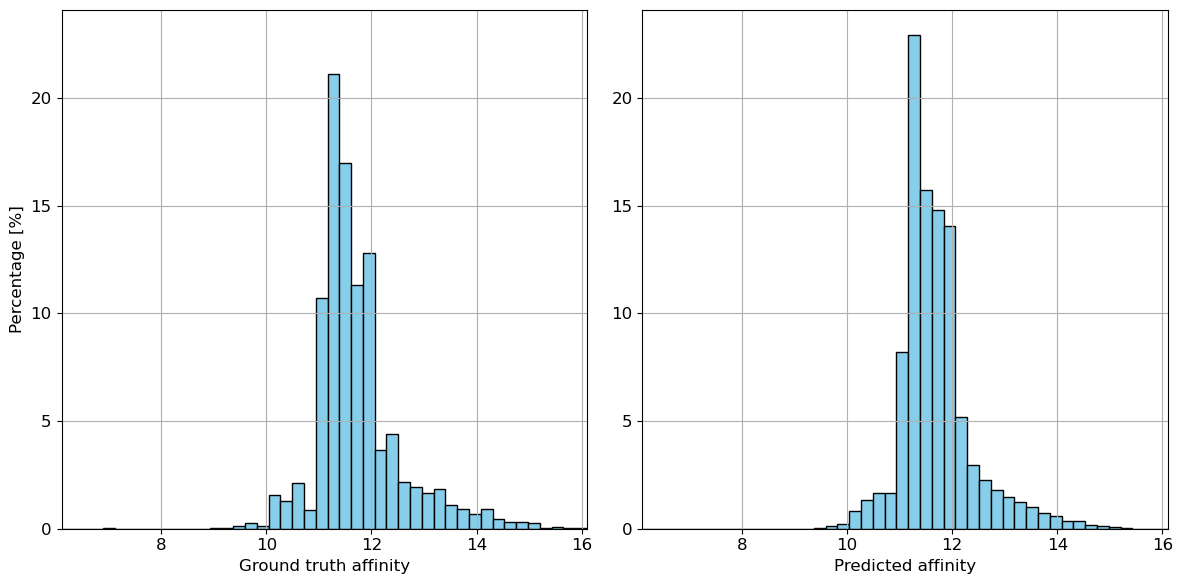

In [16]:
histogram_dir = '../results/histograms/'
os.makedirs(histogram_dir, exist_ok=True)

plot_histograms(G, P_avg, save_dir = histogram_dir + group_name)
# plot_histograms(G_concat, P_concat)


In [37]:
def plot_histogram_overlay_with_kde(labels, predictions, save_dir=None, bins=50, alpha=0.4):
    G = np.asarray(labels)
    P = np.asarray(predictions)
    xmin = min(G.min(), P.min())
    xmax = max(G.max(), P.max())

    plt.figure(figsize=(8, 6))

    # Create shared bin edges so both histograms align
    bin_edges = np.linspace(np.floor(xmin), np.ceil(xmax), bins)

    # Plot histograms as density with low alpha using standard tab colors
    sns.histplot(G, bins=bin_edges, color='tab:blue', stat='density', label='Ground truth', alpha=alpha, kde=False, edgecolor='gray')
    sns.histplot(P, bins=bin_edges, color='tab:orange', stat='density', label='Predictions', alpha=alpha, kde=False, edgecolor='gray')

    # Add KDE overlays in matching colors
    sns.kdeplot(G, color='tab:blue', linewidth=2)
    sns.kdeplot(P, color='tab:orange', linewidth=2)

    plt.xlim([xmin, xmax])
    plt.xlabel('Affinity')
    plt.ylabel('Density')
    # plt.title('Overlayed Histograms with KDE')
    plt.legend()
    plt.grid(True, 0.5)
    plt.tight_layout()

    if save_dir is not None:
        plt.savefig(save_dir, dpi=500)
    plt.show()

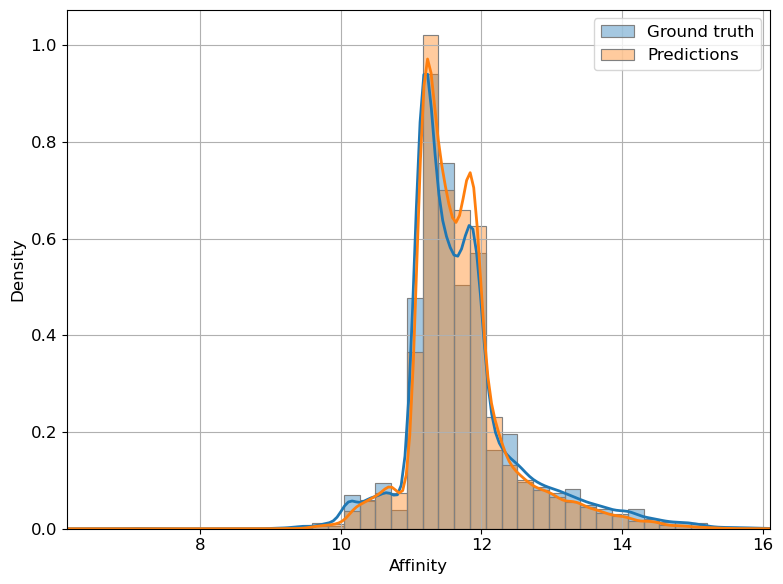

In [91]:
kde_path = '../results/kde_histograms/'
os.makedirs(kde_path, exist_ok=True)

# plot_histogram_overlay_with_kde(G, P_avg, save_dir = kde_path + group_name)
plot_histogram_overlay_with_kde(G, P_avg)

# plot_histogram_overlay_with_kde(G_concat, P_concat)

In [36]:
from scipy.stats import spearmanr
def plot_scatter(labels, predictions, save_dir = None):
    G = labels
    P = predictions

    plt.figure(figsize=(6, 6))
    plt.scatter(P, G, alpha=0.5, marker='.')
    plt.xlabel('Predicted affinity')
    plt.ylabel('Ground truth affinity')
    # plt.title('Scatter plot of predictions vs labels')
    plt.grid(True, 0.5)

    # Equal limits
    min_val = min(G.min(), P.min())
    max_val = max(G.max(), P.max())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # y=x line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Spearman correlation in lower-right
    spearman_corr, _ = spearmanr(G, P)
    plt.annotate(
        f"Spearman: {spearman_corr:.3f}",
        xy=(0.95, 0.05),
        xycoords='axes fraction',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#444", alpha=0.8)
    )
    
    plt.tight_layout()

    if save_dir is not None:
        plt.savefig(save_dir, dpi=500)
    plt.show()

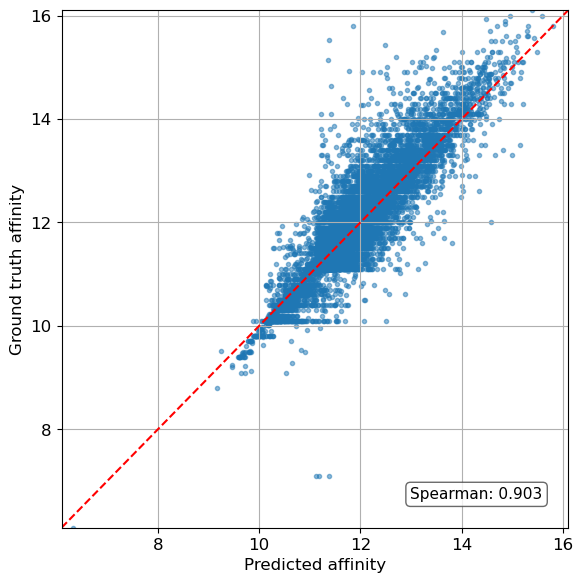

In [88]:
scatter_dir = '../results/scatter_plots/'
os.makedirs(scatter_dir, exist_ok=True)
# plot_scatter(G, P_avg, save_dir = scatter_dir + group_name)
plot_scatter(G, P_avg)

In [ ]:
# Ensure P_avg is in the dataframe
if 'prediction_avg' not in prediction_dataframe.columns:
    prediction_dataframe['prediction_avg'] = P_avg

def calculate_ci_per_protein(group):
    if len(group) < 2:
        return np.nan
    # CI is undefined if all ground truth values are the same
    if len(group['affinity'].unique()) == 1:
        return np.nan
    
    # Use the ci function from utils.py
    # ci(y, f) where y is ground truth and f is prediction
    return ci(group['affinity'].values, group['prediction_avg'].values)

# 1. Calculate CI for each protein
print("Calculating CI per protein...")
protein_ci_df = prediction_dataframe.groupby('protein_key').apply(calculate_ci_per_protein).reset_index()
protein_ci_df.columns = ['protein_key', 'ci']

# Filter out NaNs (proteins with <2 samples or constant affinity)
protein_ci_df = protein_ci_df.dropna()

# Add ligand counts per protein
ligand_counts = prediction_dataframe['protein_key'].value_counts().reset_index()
ligand_counts.columns = ['protein_key', 'num_ligands']
protein_ci_df = pd.merge(protein_ci_df, ligand_counts, on='protein_key', how='left')

# Sort by CI
protein_ci_df = protein_ci_df.sort_values(by='ci')

# 2. Identify worst and best performing proteins
print("\nTop 10 Worst Performing Proteins (Lowest CI):")
print(protein_ci_df.head(10))

Calculating CI per protein...

Top 10 Worst Performing Proteins (Lowest CI):
    protein_key        ci  num_ligands
111      P51813  0.000000            2
193      Q9BWU1  0.458333           26
65       P23458  0.500000            6
122      P54646  0.529412           10
187      Q96L34  0.666667            3
88       P42345  0.692722           28
0        O00141  0.702703           22
158      Q14012  0.704071          125
174      Q16644  0.705882          112
102      P49759  0.714286            6


/tmp/ipykernel_3923016/2117455562.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  protein_ci_df = prediction_dataframe.groupby('protein_key').apply(calculate_ci_per_protein).reset_index()


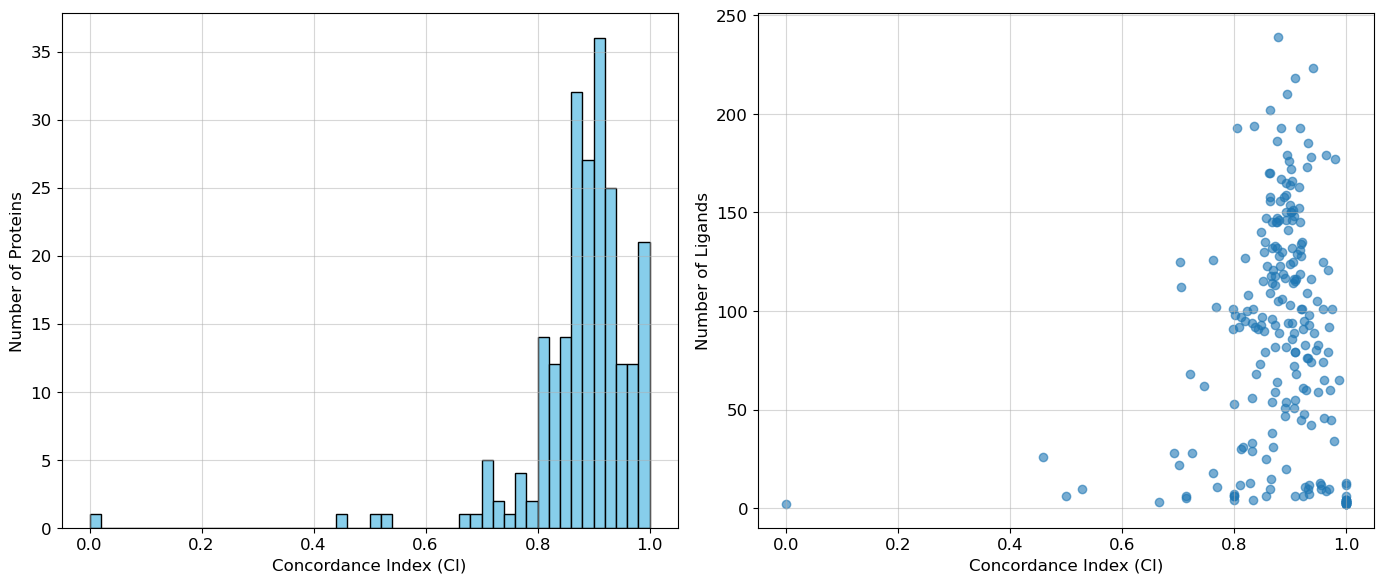

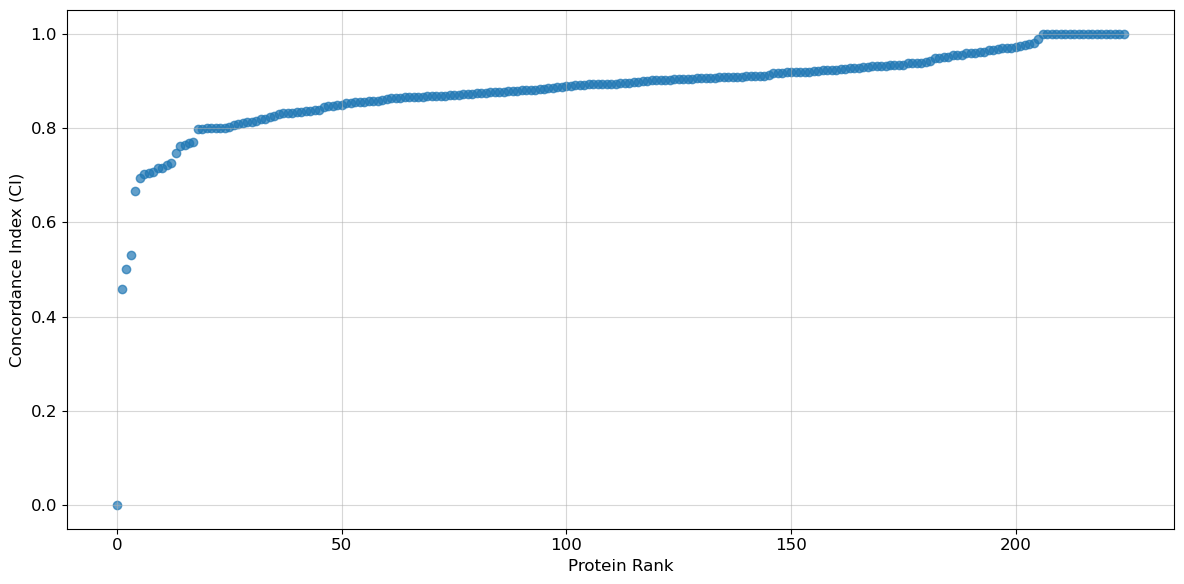

In [ ]:
ci_analysis_path = '../results/ci_analysis/'
os.makedirs(ci_analysis_path, exist_ok=True)

# Save worst performing proteins to CSV
worst_proteins = protein_ci_df.head(10)
worst_proteins.to_csv(ci_analysis_path + 'worst_performing_proteins_' + group_name + '.csv', index=False)

# 3. Visualizations
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of CI distribution
axs[0].hist(protein_ci_df['ci'], bins=50, color='skyblue', edgecolor='black')
axs[0].set_xlabel('Concordance Index (CI)')
axs[0].set_ylabel('Number of Proteins')
# axs[0].set_title('Distribution of CI per Protein')
axs[0].grid(True, alpha=0.5)

# CI vs Number of Ligands
axs[1].scatter(protein_ci_df['ci'], protein_ci_df['num_ligands'], alpha=0.6, marker='o')
axs[1].set_ylabel('Number of Ligands')
axs[1].set_xlabel('Concordance Index (CI)')
# axs[1].set_title('CI vs Number of Ligands per Protein')
axs[1].grid(True, alpha=0.5)

fig.tight_layout()
fig.savefig(ci_analysis_path + 'ci_per_proteins_and_ligands_' + group_name + '.png', dpi=500, bbox_inches='tight')
plt.show()

# Concordance Plot (CI per Protein Sorted)
if 'protein_ci_df' in locals():
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(protein_ci_df))
    y = protein_ci_df['ci'].values
    
    # Single-color scatter (no colormap, no colorbar, no labels/annotations)
    ax2.scatter(x, y, alpha = 0.7, marker='o')
    ax2.set_xlabel('Protein Rank')
    ax2.set_ylabel('Concordance Index (CI)')
    # ax2.set_title('Concordance Index per Protein (Sorted)')
    ax2.grid(True, alpha=0.5)
    
    fig2.tight_layout()
    fig2.savefig(ci_analysis_path + 'ci_per_proteins_sorted_' + group_name + '.png', dpi=500, bbox_inches='tight')
    plt.show()
else:
    print("Error: 'protein_ci_df' not found. Please run the previous cell to calculate CI per protein.")